In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [16]:
img = cv2.imread("data/daisy/5547758_eea9edfd54_n.jpg")

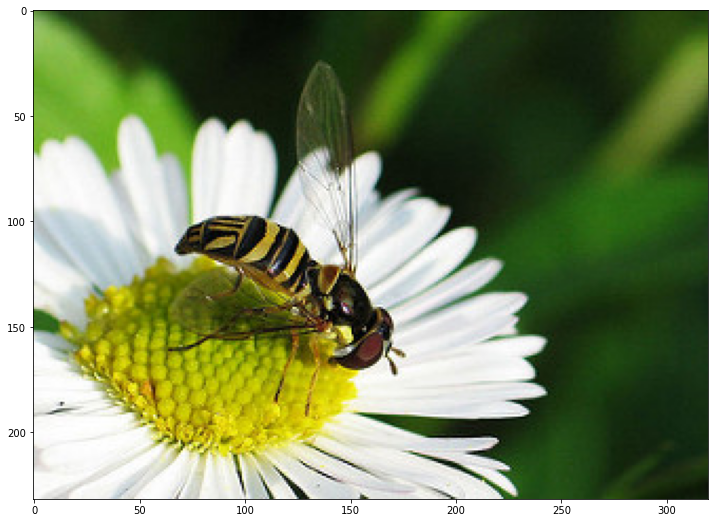

In [17]:
plt.rcParams["figure.figsize"] = (16, 9)

plt.imshow(img[:,:,::-1])
plt.show()

In [18]:
img = tf.image.resize_with_crop_or_pad(img, 192, 192).numpy().astype(np.uint8)
img.shape

(192, 192, 3)

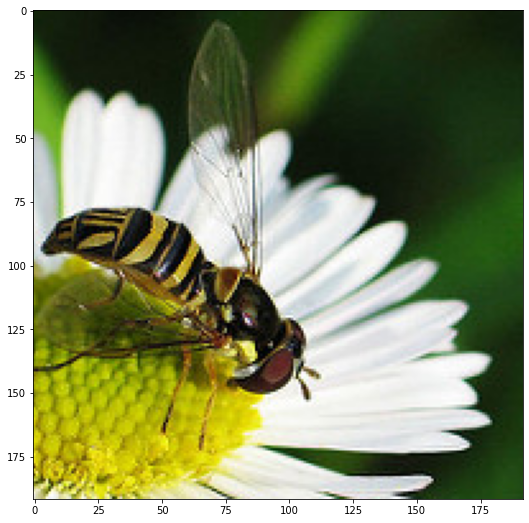

In [19]:
plt.imshow(img[:, :, ::-1])
plt.show()

In [20]:
imgf32 = (img / 255).astype(np.float32)
imgf32.shape, imgf32.dtype

((192, 192, 3), dtype('float32'))

In [21]:
gx = cv2.Sobel(imgf32, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(imgf32, cv2.CV_32F, 0, 1, ksize=1)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
mag.shape, angle.shape

((192, 192, 3), (192, 192, 3))

In [22]:
# take max of mag along BGR channels
max_mag_mask = np.argmax(mag, axis=2, keepdims=True)

In [23]:
# apply the mask to both mag and angle matrix
mag = np.take_along_axis(mag, max_mag_mask, axis=2).squeeze()
angle = np.take_along_axis(angle, max_mag_mask, axis=2).squeeze()
mag.shape, angle.shape

((192, 192), (192, 192))

In [24]:
# map the function to the angle vector to get "unsigned" gradients
np.vectorize(lambda x: x - 180 if x > 180 else x)(angle)
angle

array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [ 90.      ,   0.      ,  90.      , ..., 270.      , 270.      ,
        270.      ],
       [ 90.      ,  44.990456,  44.990456, ..., 270.      ,  26.567104,
        270.      ],
       ...,
       [ 90.      , 207.32513 , 215.65773 , ..., 111.805855, 111.805855,
         90.      ],
       [270.      , 189.94037 , 189.08984 , ..., 158.19412 , 116.56711 ,
         90.      ],
       [  0.      , 180.      , 180.      , ..., 180.      , 180.      ,
          0.      ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


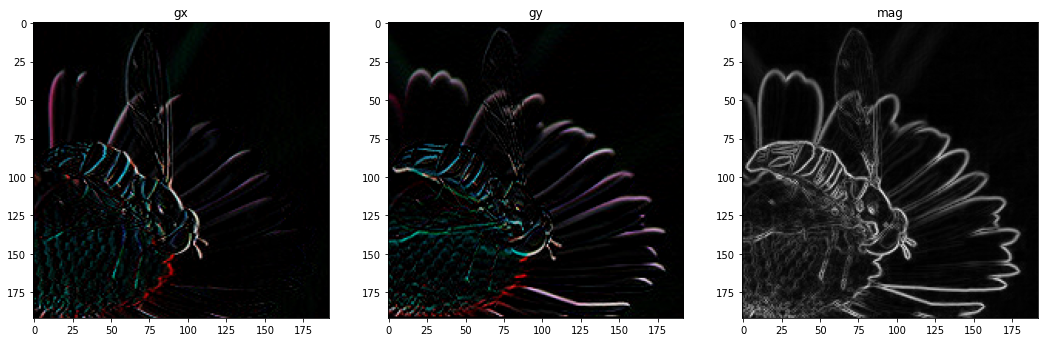

In [25]:
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 3, 1)
plt.imshow(gx)
plt.title("gx")

plt.subplot(1, 3, 2)
plt.imshow(gy)
plt.title("gy")

plt.subplot(1, 3, 3)
plt.imshow(mag, "gray")
plt.title("mag")

plt.show()

In [43]:
def hog(angles, mag, p_size=8, bins=9):
    hog = np.zeros(shape=(img.shape[0] // p_size, img.shape[1] // p_size, bins))
    for i in range(img.shape[0] // p_size):
        for j in range(img.shape[1] // p_size):
            # take a patch
            patch_angles = angle[i * p_size: (i + 1) * p_size, j * p_size: (j + 1) * p_size]
            patch_mag = mag[i * p_size: (i + 1) * p_size, j * p_size: (j + 1) * p_size]

            hist, _ = np.histogram(patch_angles, bins=bins, range=(0, 180), weights=patch_mag)
            hog[i, j] = hist / (hist.max() + 1)
    return hog

In [44]:
img_hog = hog(angle, mag, p_size=16, bins=9)
img_hog.shape

(12, 12, 9)

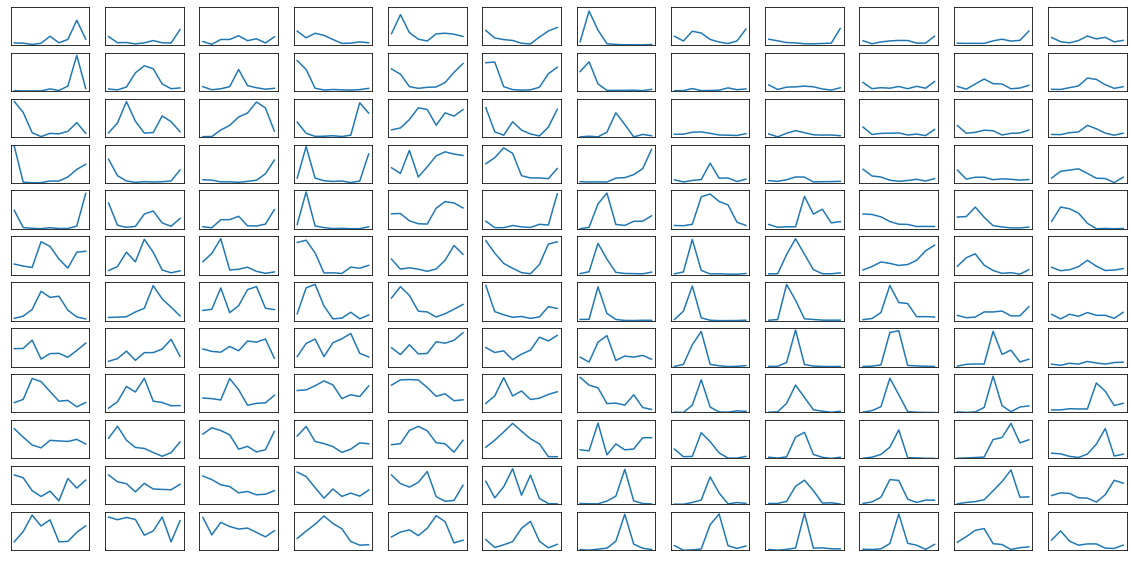

In [45]:
plt.rcParams["figure.figsize"] = (20, 10)
for i in range(img_hog.shape[0]):
    for j in range(img_hog.shape[1]):
        plt.subplot(img_hog.shape[0], img_hog.shape[1], i * img_hog.shape[0] + j + 1)
        plt.plot(range(0, 180, 20), img_hog[i, j])
        plt.xticks([])
        plt.yticks([])
        plt.ylim([0, 1])
plt.show()